In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [1]:
import torch
from graphxai.datasets import ShapeGGen
from graphxai.explainers import GNNExplainer, PGExplainer, GraphLIME, IntegratedGradExplainer, SubgraphX, PGMExplainer
from graphxai.metrics import graph_exp_acc, graph_exp_faith
# from graphxai.visualization import ExplanationVisualizer
import matplotlib.pyplot as plt


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv, GATConv, GATv2Conv, SAGEConv

class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, out_dim)

    def forward(self, x, edge_index,):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        
        return x


class GIN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GINConv(torch.nn.Linear(in_dim, hidden_dim))
        self.conv2 = GINConv(torch.nn.Linear(hidden_dim, hidden_dim))
        self.conv3 = GINConv(torch.nn.Linear(hidden_dim, out_dim))

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        
        return x

class GAT(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=8, dropout=0.5):
        super().__init__()
        self.conv1 = GATv2Conv(in_dim, hidden_dim, heads=heads, dropout=dropout)
        self.conv2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=heads, dropout=dropout)
        self.conv3 = GATv2Conv(hidden_dim * heads, out_dim, heads=1, concat=False, dropout=dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.conv3(x, edge_index)
        
        return x


class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, out_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        
        return x


In [3]:
in_dim  = 1433
hidden_dim = 32
out_dim = 7

models = {
    'GIN': GIN(in_dim, hidden_dim, out_dim).to(device),
    'GCN': GCN(in_dim, hidden_dim, out_dim).to(device),
    'GAT': GAT(in_dim, hidden_dim, out_dim).to(device),
    'GraphSAGE': GraphSAGE(in_dim, hidden_dim, out_dim).to(device)
}

In [4]:
from graphxai.datasets.cora import Cora

dataset = Cora()
batch_size = 64
# train_loader = dataset.get_train_loader(batch_size=batch_size)[0]
# val_loader = dataset.get_val_loader()[0]
# test_loader = dataset.get_test_loader()[0]

In [5]:
from graphxai.gnn_models.node_classification import train, test


data = dataset.get_graph(use_fixed_split=True).to(device)

for model_name, model in models.items():
    print("\n\t" + model_name)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss().to(device)

    for epoch in range(300):
        train(model, optimizer, criterion, data)
        # f1, _, _, _, auc = test(model, val_loader)

        # print(f'epoch: {epoch+1:1d}, val F1: {f1:.4f}, val AUC: {auc:.4f}')

    acc, f1 = test(model, data, num_classes=7, get_auc=False)
    print(f'test F1: {f1:.4f}, test ACC: {acc:.4f}')


	GIN
test F1: 0.7230, test ACC: 0.7230

	GCN
test F1: 0.7920, test ACC: 0.7920

	GAT
test F1: 0.7690, test ACC: 0.7690

	GraphSAGE
test F1: 0.7870, test ACC: 0.7870


In [6]:

for model_name, model in models.items():
    acc, f1 = test(model, data, num_classes=7, get_auc=False)
    print(f"{model_name}: {f1}")

GIN: 0.73
GCN: 0.784
GAT: 0.776
GraphSAGE: 0.785


In [269]:
test_graph, explanation = dataset.get_test_w_label(0)
test_graph.edge_index

tensor([[ 1,  0,  2,  1,  3,  2,  4,  3,  5,  3,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11, 10, 12, 11, 13, 11, 14,  9, 15, 14, 16, 15, 17, 16, 18, 16,
         19, 18, 20, 19, 21, 20, 22, 21, 23, 22,  5, 10, 19, 23],
        [ 0,  1,  1,  2,  2,  3,  3,  4,  3,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10, 10, 11, 11, 12, 11, 13,  9, 14, 14, 15, 15, 16, 16, 17, 16, 18,
         18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 10,  5, 23, 19]])

In [ ]:
len(dataset.get_train_loader()[0].dataset)

140

In [309]:
from graphxai.explainers import PGExplainer, IntegratedGradExplainer, GNNExplainer, SubgraphX, RandomExplainer


# null_batch = torch.zeros(1).long().cuda()
# forward_kwargs = {'batch': null_batch}

explainers = {model_name: {} for model_name in models}

for idx, (name, model) in enumerate(models.items()):
    in_channels = (14 if name in ["GAT", "GraphSAGE"] else None)
    pgex = PGExplainer(model, emb_layer_name='conv3', in_channels=in_channels, max_epochs=20)
    pgex.train_explanation_model(data)

    igex = IntegratedGradExplainer(model, criterion=criterion)
    gnnex = GNNExplainer(model)
    rndex = RandomExplainer(model)
    
    subex = SubgraphX(model)

    explainers[name] = {
        "PGExplainer": pgex,
        "GNNExplainer": gnnex,
        "RandomExplainer": rndex,
        "IntegratedGradExplainer": igex,
        "SubgraphX": subex,
    }


140it [00:00, 200.77it/s]
140it [00:00, 171.30it/s]
140it [00:00, 177.70it/s]
140it [00:00, 174.90it/s]
140it [00:00, 174.38it/s]
140it [00:00, 165.11it/s]
140it [00:00, 185.33it/s]
140it [00:00, 219.48it/s]
140it [00:00, 219.37it/s]
140it [00:00, 190.29it/s]
140it [00:00, 179.24it/s]
140it [00:00, 185.18it/s]
140it [00:00, 187.99it/s]
140it [00:00, 214.34it/s]
140it [00:00, 201.05it/s]
140it [00:00, 176.90it/s]
140it [00:00, 178.69it/s]
140it [00:00, 179.76it/s]
140it [00:00, 182.43it/s]
140it [00:00, 177.56it/s]
140it [00:00, 175.06it/s]


training time is 15.23s


140it [00:00, 243.29it/s]
140it [00:00, 158.50it/s]
140it [00:01, 130.92it/s]
140it [00:01, 119.81it/s]
140it [00:00, 145.74it/s]
140it [00:00, 143.35it/s]
140it [00:00, 149.74it/s]
140it [00:00, 147.46it/s]
140it [00:01, 139.77it/s]
140it [00:01, 133.01it/s]
140it [00:01, 115.42it/s]
140it [00:01, 115.95it/s]
140it [00:01, 130.71it/s]
140it [00:01, 125.27it/s]
140it [00:01, 122.72it/s]
140it [00:01, 130.78it/s]
140it [00:01, 120.89it/s]
140it [00:01, 131.64it/s]
140it [00:01, 127.42it/s]
140it [00:01, 131.88it/s]
140it [00:01, 122.61it/s]


training time is 21.402s


140it [00:00, 142.03it/s]
140it [00:01, 106.81it/s]
140it [00:01, 105.64it/s]
140it [00:01, 104.59it/s]
140it [00:01, 109.28it/s]
140it [00:01, 109.32it/s]
140it [00:01, 131.20it/s]
140it [00:01, 111.61it/s]
140it [00:01, 111.15it/s]
140it [00:01, 112.55it/s]
140it [00:01, 134.12it/s]
140it [00:01, 113.73it/s]
140it [00:01, 109.24it/s]
140it [00:01, 111.80it/s]
140it [00:01, 111.71it/s]
140it [00:01, 129.20it/s]
140it [00:01, 120.60it/s]
140it [00:01, 103.80it/s]
140it [00:01, 113.25it/s]
140it [00:00, 150.38it/s]
140it [00:00, 144.22it/s]


training time is 24.22s


140it [00:00, 358.59it/s]
140it [00:00, 235.89it/s]
140it [00:00, 219.59it/s]
140it [00:00, 203.03it/s]
140it [00:00, 178.77it/s]
140it [00:00, 197.91it/s]
140it [00:00, 227.95it/s]
140it [00:00, 234.73it/s]
140it [00:00, 191.79it/s]
140it [00:00, 183.92it/s]
140it [00:00, 187.63it/s]
140it [00:00, 212.50it/s]
140it [00:00, 214.31it/s]
140it [00:00, 182.72it/s]
140it [00:00, 180.21it/s]
140it [00:00, 188.15it/s]
140it [00:00, 210.06it/s]
140it [00:00, 182.58it/s]
140it [00:00, 166.39it/s]
140it [00:00, 170.96it/s]
140it [00:00, 169.51it/s]

training time is 14.434s


In [8]:
test_dataloader, explanations = dataset.get_test_loader()
import random

graph_ind = random.randint(0, len(test_dataloader.dataset))

print(graph_ind)
test_graph = test_dataloader.dataset[graph_ind].to(device)
test_explanation = explanations[graph_ind][0]

test_graph.node_idx

90


tensor([0], device='cuda:0')

In [333]:
node_idx, gt_exp = dataset.choose_node(split = 'test')
# while len(gt_exp[0].node_imp) > 50:
#     node_idx, gt_exp = dataset.choose_node(split = 'test')
print(data.y[node_idx])

tensor(4, device='cuda:0')


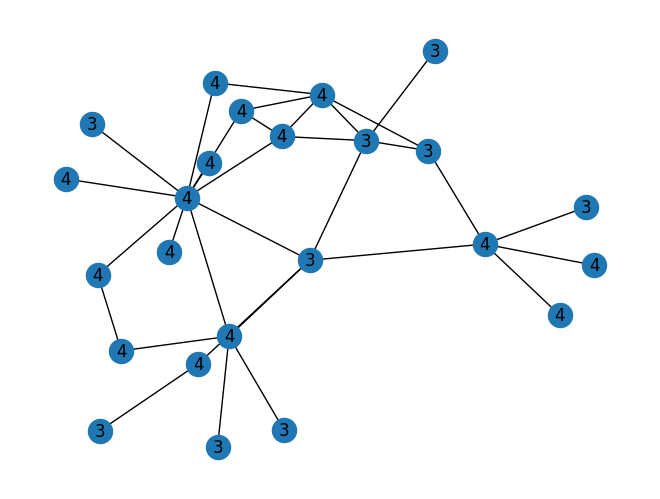

In [42]:
import graphxai.utils as gxai_utils

wholeG = gxai_utils.to_networkx_conv(data, to_undirected=True)
kadd_hop_neighborhood = gxai_utils.khop_subgraph_nx(
                G = wholeG, 
                num_hops= 2 + 1, 
                node_idx= node_idx
            )

subG = wholeG.subgraph(kadd_hop_neighborhood)

import networkx as nx

labels = {node: data.y[node].item() for node in subG.nodes()}
nx.draw(subG, with_labels=True, labels=labels)

#### Features

In [81]:
from collections import Counter

k = 10
features_imp = {name: Counter() for name in ['GNNExplainer', 'PGExplainer', 'IntegratedGradExplainer']}
model = models['GIN']
for _ in range(k):
    for exp_name in ['GNNExplainer', 'PGExplainer', 'IntegratedGradExplainer']:
        expl = explainers['GIN'][exp_name]
        explanation = expl.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)
        features = []
        # print(exp_name)
        try:
            for i,v in enumerate(explanation.top_k_feature_imp(10)):
                if v:
                    features.append(i)
            features_imp[exp_name] += Counter(features)
            # print(features)
        except:
            continue
for name, vals in features_imp.items():
    print(name, vals)

GNNExplainer Counter({108: 2, 271: 1, 348: 1, 350: 1, 409: 1, 471: 1, 572: 1, 712: 1, 986: 1, 1305: 1, 1331: 1, 53: 1, 148: 1, 461: 1, 803: 1, 842: 1, 992: 1, 1032: 1, 1086: 1, 1149: 1, 1246: 1, 246: 1, 466: 1, 527: 1, 585: 1, 704: 1, 949: 1, 1083: 1, 1145: 1, 1243: 1, 1427: 1, 4: 1, 200: 1, 219: 1, 432: 1, 691: 1, 872: 1, 953: 1, 1141: 1, 1232: 1, 1336: 1, 208: 1, 467: 1, 537: 1, 584: 1, 608: 1, 648: 1, 717: 1, 933: 1, 974: 1, 1407: 1, 282: 1, 592: 1, 606: 1, 621: 1, 639: 1, 663: 1, 730: 1, 1128: 1, 1281: 1, 1298: 1, 64: 1, 145: 1, 183: 1, 242: 1, 302: 1, 507: 1, 531: 1, 546: 1, 553: 1, 241: 1, 243: 1, 480: 1, 751: 1, 802: 1, 935: 1, 985: 1, 1363: 1, 1397: 1, 11: 1, 104: 1, 142: 1, 587: 1, 791: 1, 883: 1, 1156: 1, 1299: 1, 1318: 1, 1378: 1, 18: 1, 351: 1, 388: 1, 431: 1, 479: 1, 884: 1, 952: 1, 1026: 1, 1127: 1, 1428: 1})
PGExplainer Counter()
IntegratedGradExplainer Counter({291: 10, 378: 10, 474: 10, 507: 10, 801: 10, 1131: 10, 1328: 10, 1333: 10, 1379: 10, 1432: 10})


In [265]:
features_imp = {i: [] for i in range(7)}
visited = set()
expl = explainers['GIN']['IntegratedGradExplainer']

for _ in range(500):
    node_idx, gt_exp = dataset.choose_node(split = 'test')
    # while len(gt_exp[0].node_imp) > 50:
    #     node_idx, gt_exp = dataset.choose_node(split = 'test')
    label = data.y[node_idx]
    if node_idx in visited:
        continue
    visited.add(node_idx)

    explanation = expl.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)
    features = []
    for i,v in enumerate(explanation.top_k_feature_imp(10)):
        if v:
            features.append(i)
    features_imp[int(label)].extend(features)


In [303]:
vis = {}
for k,v in features_imp.items():
    c = Counter(v)
    vis[k] = sorted(c.items(), key=lambda x: x[1], reverse=True)[5:10]

In [304]:
vis

{0: [(1428, 14), (1424, 10), (1427, 10), (1177, 9), (1075, 8)],
 1: [(1429, 11), (1427, 9), (1426, 8), (1075, 7), (19, 6)],
 2: [(1429, 13), (1328, 10), (1428, 10), (1348, 10), (1177, 10)],
 3: [(1429, 27), (1428, 23), (1263, 22), (1131, 21), (1427, 21)],
 4: [(1428, 23), (1427, 17), (1426, 13), (774, 10), (1301, 8)],
 5: [(19, 11), (1429, 10), (774, 8), (1428, 7), (1209, 7)],
 6: [(1429, 12), (1428, 9), (1144, 6), (1427, 6), (128, 6)]}

In [305]:
features_imp = {i: [] for i in range(7)}
visited = set()
expl = explainers['GIN']['IntegratedGradExplainer']

for _ in range(500):
    node_idx, gt_exp = dataset.choose_node(split = 'test')
    # while len(gt_exp[0].node_imp) > 50:
    #     node_idx, gt_exp = dataset.choose_node(split = 'test')
    label = data.y[node_idx]
    if node_idx in visited:
        continue
    visited.add(node_idx)

    explanation = expl.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)
    features = []
    for i,v in enumerate(explanation.top_k_feature_imp(10)):
        if v:
            features.append(i)
    features_imp[int(label)].extend(features)


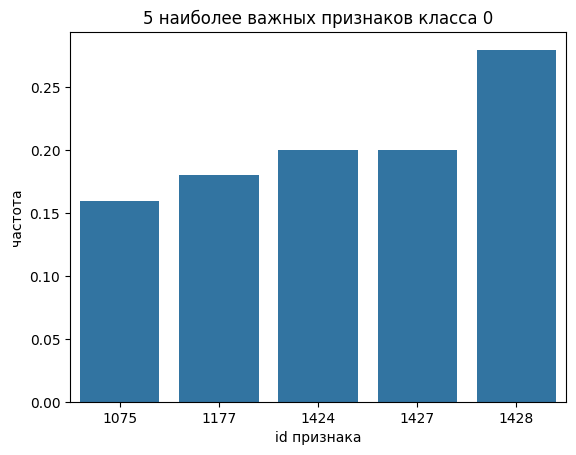

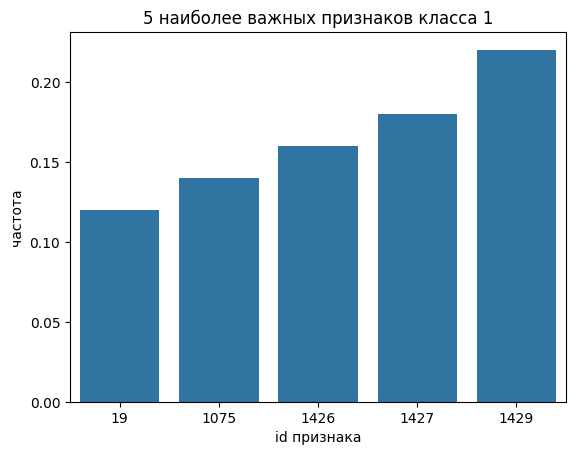

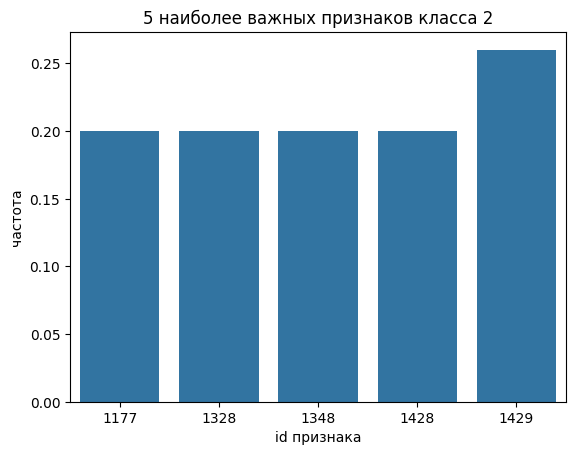

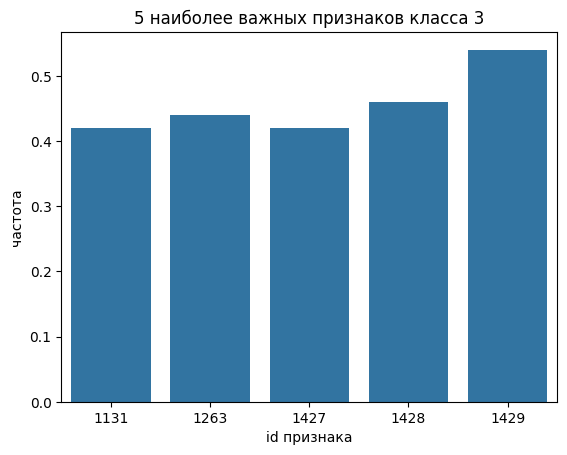

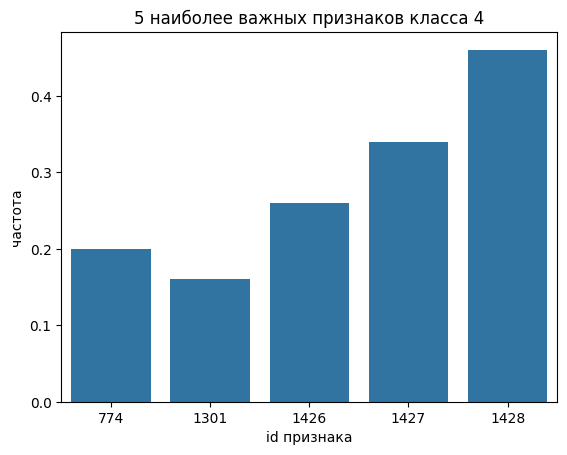

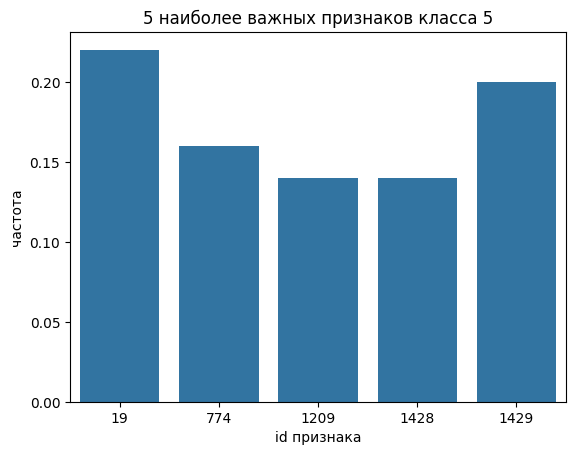

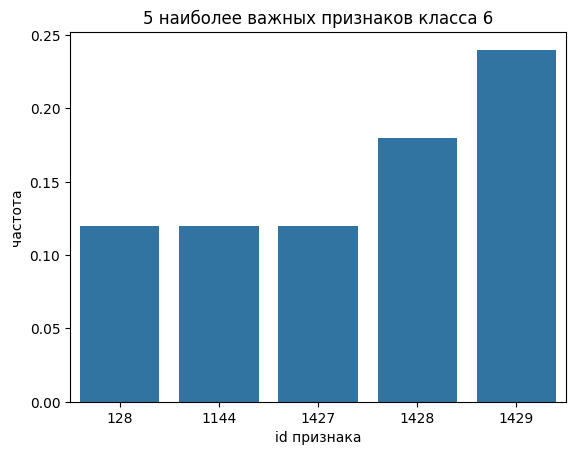

In [320]:
import seaborn as sns

for cls, features in vis.items():
    labels, values = zip(*features)
    sns.barplot(y=np.array(values)/50, x=labels)
    plt.title(f"5 наиболее важных признаков класса {cls}")
    plt.xlabel("id признака")
    plt.ylabel("частота")
    plt.show()

In [32]:
features = []
for i,v in enumerate(explanation.top_k_feature_imp(10)):
    if v:
        features.append(i)
print(features)

[357, 403, 520, 853, 902, 915, 1221, 1275, 1286, 1423]


#### Visual

GIN
GCN
GAT
GraphSAGE


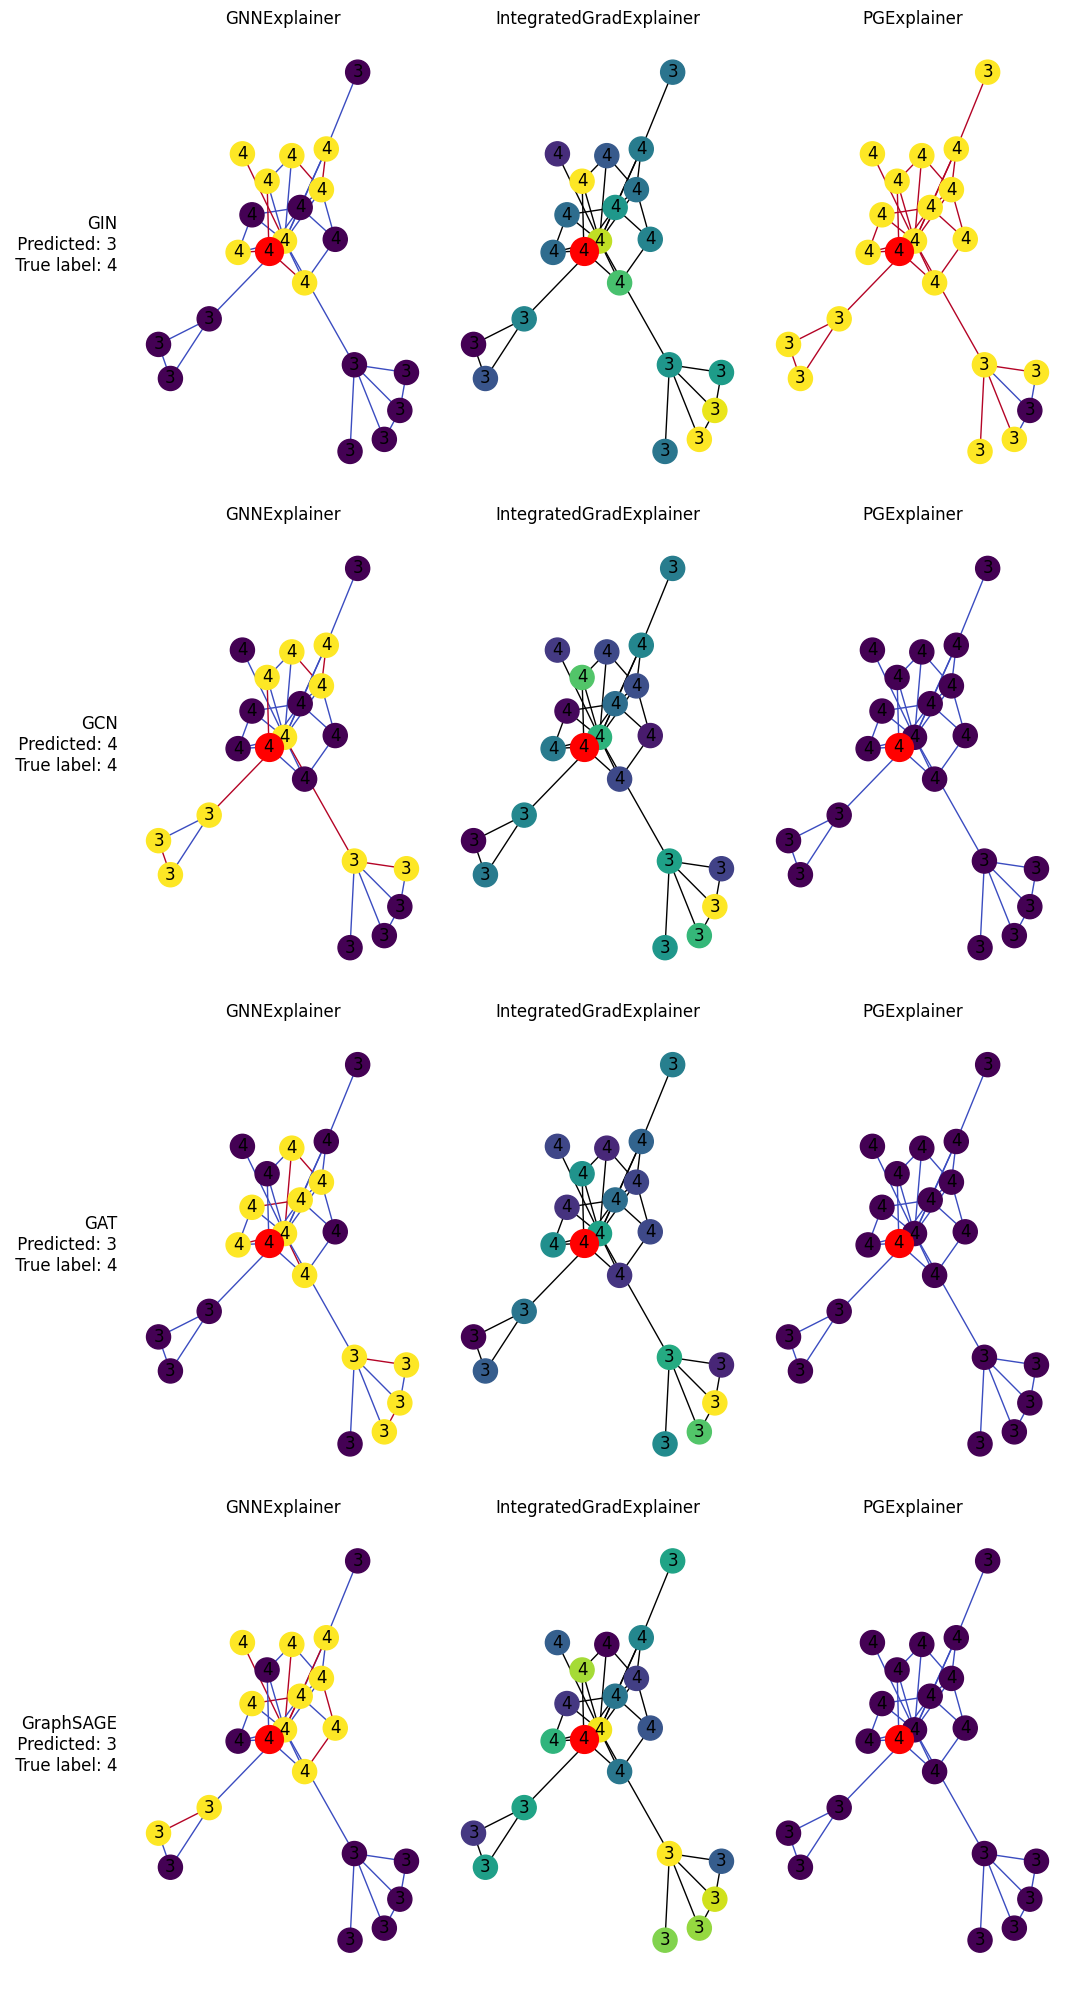

In [334]:
fig, ax = plt.subplots(len(models), 3, figsize = (10, 20))

# data.to('cuda')

for idx, (name, model) in enumerate(models.items()):
    
    print(name)
    pgex, gnnex, rndex, igex, subex = explainers[name].values()

    pg_exp = pgex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)
    ig_exp = igex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)
    gnn_exp = gnnex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)

    # rnd_ex = rndex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index )

    # ax[idx, 0].set_title('Исходный вид')
    ax[idx, 0].set_title('GNNExplainer')
    ax[idx, 1].set_title('IntegratedGradExplainer')
    ax[idx, 2].set_title('PGExplainer')
    # ax[idx, 0].set_title('RandomExplainer')

    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    
    fig.text(0.04, (1 - (idx + 0.5) / len(models)), f"{name}\n Predicted: {pred[node_idx]}\n True label: {data.y[node_idx]}", va='center', ha='right', fontsize=12)

    # gt_exp[0].visualize_node(num_hops = 3, graph_data = data, ax = ax[idx, 0])
    gnn_exp.visualize_node(num_hops = 2, graph_data = data, ax = ax[idx, 0], true_labels=data.y, show_node_labels=True)
    ig_exp.visualize_node(num_hops = 2, graph_data = data, ax = ax[idx, 1], true_labels=data.y, show_node_labels=True)
    pg_exp.visualize_node(num_hops = 2, graph_data = data, ax = ax[idx, 2], true_labels=data.y, show_node_labels=True)
    # rnd_ex.visualize_node(num_hops = 2, graph_data = data, ax = ax[idx, 0])

plt.tight_layout(rect=[0.04, 0, 1, 1])
plt.show()

In [50]:
torch.cuda.empty_cache()

In [21]:
from graphxai.utils.perturb import rewire_edges, perturb_node_features

def graph_exp_faith(generated_exp, shape_graph, model, sens_idx = [], top_k = 0.25, device=device):
    '''
    Args:
        gt_exp (Explanation): Ground truth explanation from the dataset.
        generated_exp (Explanation): Explanation output by an explainer.
    '''

    GEF_feat = None
    GEF_node = None
    GEF_edge = None

    # Accessing the enclosing subgraph. Will be the same for both explanation.:
    exp_subgraph = generated_exp.enc_subgraph

    # Getting the softmax vector for the original graph
    org_vec = model(shape_graph.get_graph().x, shape_graph.get_graph().edge_index)[generated_exp.node_idx]
    org_softmax = F.softmax(org_vec, dim=-1)

    if generated_exp.feature_imp is not None:
        # Identifying the top_k features in the node attribute feature vector
        top_k_features = generated_exp.feature_imp.topk(int(generated_exp.feature_imp.shape[0] * top_k))[1]

        # Getting the softmax vector for the perturbed graph
        pert_x = shape_graph.get_graph().x.clone()

        # Perturbing the unimportant node feature indices using gaussian noise
        rem_features = torch.Tensor(
            [i for i in range(shape_graph.get_graph().x.shape[1]) if i not in top_k_features]).long()

        pert_x[generated_exp.node_idx, rem_features] = perturb_node_features(x=pert_x, node_idx=generated_exp.node_idx, pert_feat=rem_features, bin_dims=sens_idx, device=device)

        pert_vec = model(pert_x, shape_graph.get_graph().edge_index)[generated_exp.node_idx]
        pert_softmax = F.softmax(pert_vec, dim=-1)
        GEF_feat = 1 - torch.exp(-F.kl_div(org_softmax.log(), pert_softmax, None, None, 'sum')).item()

    if generated_exp.node_imp is not None:

        # Identifying the top_k nodes in the explanation subgraph
        top_k_nodes = generated_exp.node_imp.topk(int(generated_exp.node_imp.shape[0] * top_k))[1]

        rem_nodes = []
        for node in range(generated_exp.node_imp.shape[0]):
            if node not in top_k_nodes:
                rem_nodes.append([k for k, v in generated_exp.node_reference.items() if v == node][0])

        # Getting the softmax vector for the perturbed graph
        pert_x = shape_graph.get_graph().x.clone()

        # Removing the unimportant nodes by masking
        pert_x[rem_nodes] = torch.zeros_like(pert_x[rem_nodes])
        pert_vec = model(pert_x, shape_graph.get_graph().edge_index)[generated_exp.node_idx]
        pert_softmax = F.softmax(pert_vec, dim=-1)
        GEF_node = 1 - torch.exp(-F.kl_div(org_softmax.log(), pert_softmax, None, None, 'sum')).item()

    if generated_exp.edge_imp is not None:
        subgraph_edges = torch.where(generated_exp.enc_subgraph.edge_mask == True)[0]
        # Get the list of all edges that we need to keep
        device = generated_exp.edge_imp.device  # Устройство, где находится edge_imp
        subgraph_edges = subgraph_edges.to(device)  # Перемещаем subgraph_edges на нужное устройство

        # Создаем маску для всех ребер
        edge_mask = torch.zeros(shape_graph.get_graph().edge_index.shape[1], dtype=torch.bool, device=device)

        # Помечаем ребра из подграфа, которые НЕ имеют нулевой важности
        edge_mask[subgraph_edges] = (generated_exp.edge_imp != 0)

        # Собираем индексы ребер, которые нужно оставить
        keep_edges = torch.where(edge_mask)[0].tolist()

        # Get new edge_index
        edge_index = shape_graph.get_graph().edge_index[:, keep_edges]
                    
        # Getting the softmax vector for the perturbed graph
        pert_vec = model(shape_graph.get_graph().x, edge_index)[generated_exp.node_idx]
        pert_softmax = F.softmax(pert_vec, dim=-1)        
        GEF_edge = 1 - torch.exp(-F.kl_div(org_softmax.log(), pert_softmax, None, None, 'sum')).item()

    return [GEF_feat, GEF_node, GEF_edge]


def graph_exp_acc(gt_exp, generated_exp) -> float:
    '''
    Args:
        gt_exp (Explanation): Ground truth explanation from the dataset.
        generated_exp (Explanation): Explanation output by an explainer.
    '''

    EPS = 1e-09
    thresh = 0.8
    JAC_feat = None
    JAC_node = None
    JAC_edge = None 

    # Accessing the enclosing subgraph. Will be the same for both explanation.:
    exp_subgraph = generated_exp.enc_subgraph

    if generated_exp.feature_imp is not None:
        JAC_feat = []
        for exp in gt_exp:
            TPs = []
            FPs = []
            FNs = []
            true_feat = torch.where(exp.feature_imp == 1)[0]
            for i, feat in enumerate(exp.feature_imp):
                # Restore original feature numbering
                positive = generated_exp.feature_imp[i].item() > thresh
                if positive:
                    if i in true_feat:
                        TPs.append(generated_exp.feature_imp[i])
                    else:
                        FPs.append(generated_exp.feature_imp[i])
                else:
                    if i in true_feat:
                        FNs.append(generated_exp.feature_imp[i])

            TP = len(TPs)
            FP = len(FPs)
            FN = len(FNs)
            JAC_feat.append(TP / (TP + FP + FN + EPS))

        JAC_feat = max(JAC_feat)

    if generated_exp.node_imp is not None:
        JAC_node = []
        for exp in gt_exp:
            TPs = []
            FPs = []
            FNs = []
            relative_positives = (exp.node_imp == 1).nonzero(as_tuple=True)[0]
            true_nodes = [exp.enc_subgraph.nodes[i].item() for i in relative_positives]

            for i, node in enumerate(exp_subgraph.nodes):
                # Restore original node numbering
                positive = generated_exp.node_imp[i].item() > thresh
                if positive:
                    if node in true_nodes:
                        TPs.append(node)
                    else:
                        FPs.append(node)
                else:
                    if node in true_nodes:
                        FNs.append(node)
            TP = len(TPs)
            FP = len(FPs)
            FN = len(FNs)
            JAC_node.append(TP / (TP + FP + FN + EPS))

        JAC_node = max(JAC_node)

    if generated_exp.edge_imp is not None:
        JAC_edge = []
        for exp in gt_exp:
            TPs = []
            FPs = []
            FNs = []
            true_edges = torch.where(exp.edge_imp == 1)[0]
            for edge in range(exp.edge_imp.shape[0]):
                if generated_exp.edge_imp[edge]:
                    if edge in true_edges:
                        TPs.append(edge)
                    else:
                        FPs.append(edge)
                else:
                    if edge in true_edges:
                        FNs.append(edge)
            TP = len(TPs)
            FP = len(FPs)
            FN = len(FNs)
            JAC_edge.append(TP / (TP + FP + FN + EPS))

        JAC_edge = max(JAC_edge)

    return [JAC_feat, JAC_node, JAC_edge]

In [65]:
dataset.choose_node(split = 'test')

(2412, [<graphxai.utils.explanation.Explanation at 0x22b75ae89b0>])

In [66]:
dataset.get_graph()

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], valid_mask=[2708])

In [22]:
# test_graph, explanation = dataset.get_test_w_label(1)
# test_graph.to('cuda')
# model_name = "GraphSAGE"

import numpy as np
# from graphxai.metrics import graph_exp_acc, graph_exp_faith

# graphs, explanations = dataset.get_data_list(dataset.test_index)

scores = {model_name:{explainer:{} for explainer in explainers[model_name]} for model_name in models}

for model_name in models:
    print()
    print(model_name)
    for exp_name, explainer in explainers[model_name].items():
        
        accuracy = np.zeros(3)
        faithfulness = np.zeros(3)

        num_tests = 200

        for i in range(num_tests):
            node_idx, gt_exp = dataset.choose_node(split = 'test')

            if exp_name in ["RandomExplainer"]:
                gen_exp = explainer.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index)
            else:
                gen_exp = explainer.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)

            acc_feat, acc_nodes, acc_edges = graph_exp_acc(gt_exp, gen_exp)
            accuracy += [acc_feat if acc_feat != None else 0, acc_nodes, acc_edges if acc_edges else 0]

            faith_feat, faith_nodes, faith_edges = graph_exp_faith(gen_exp, dataset, models[model_name])
            faithfulness += [faith_feat if faith_feat != None else 0, faith_nodes, faith_edges if faith_edges else 0]

        accuracy /= num_tests
        faithfulness /= num_tests
        
        scores[model_name][exp_name]['accuracy'] = accuracy
        scores[model_name][exp_name]['faithfulness'] = faithfulness
        
        print('\t' + exp_name)
        print('accuracy:', accuracy)
        print('faithfulness:', faithfulness)



GIN
	PGExplainer
accuracy: [0.         0.05215175 0.1086118 ]
faithfulness: [0.                nan 0.36710162]
	GNNExplainer
accuracy: [0.         0.05909091 0.12      ]
faithfulness: [       nan 0.7245446  0.80354835]
	RandomExplainer
accuracy: [0.21250523 0.00933281 0.05764735]
faithfulness: [nan nan nan]
	IntegratedGradExplainer
accuracy: [6.97836706e-05 3.79472114e-03 0.00000000e+00]
faithfulness: [nan nan  0.]
	SubgraphX
accuracy: [0. 0. 0.]
faithfulness: [0. 0. 0.]

GCN
	PGExplainer
accuracy: [0.         0.03560966 0.07571993]
faithfulness: [0.         0.67267367 0.00115938]
	GNNExplainer
accuracy: [0.         0.01602564 0.0187931 ]
faithfulness: [0.01129501 0.60809837 0.40513567]
	RandomExplainer
accuracy: [0.21117237 0.01185077 0.07828632]
faithfulness: [0.00749391 0.65681492 0.00141906]
	IntegratedGradExplainer
accuracy: [0.         0.00142857 0.        ]
faithfulness: [0.02969659 0.79865231 0.        ]
	SubgraphX
accuracy: [0. 0. 0.]
faithfulness: [0. 0. 0.]

GAT
	PGExplaine

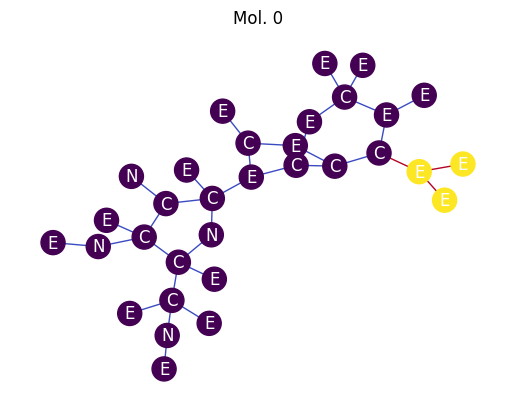

In [18]:
import networkx as nx

atom_map = {0: 'C', 1: 'N', 2: 'O'}

mutag = [dataset.get_test_w_label(1)]

for i in range(len(mutag)): #random.sample(list(range(len(mutag))), k = 5):
    g, exp = mutag[i]
    exp = exp[0]

    G, pos = exp.visualize_graph(show = False)
    #G = gxai_utils.to_networkx_conv(exp.graph, to_undirected=True)

    node_label = {}

    for j in range(exp.graph.x.shape[0]):
        ind = exp.graph.x[j,:].nonzero(as_tuple = True)[0].item()
        try:
            to_map = atom_map[ind]
        except KeyError:
            to_map = 'E'
        
        node_label[j] = to_map

    nx.draw_networkx_labels(G, pos, node_label, font_color = 'white')
    plt.title(f'Mol. {i}')
    plt.show()

In [13]:
import pandas as pd

methods = list(scores['GIN'].keys())
df_char = pd.DataFrame(index=scores.keys(), columns=methods)

for model in scores:
    for method in methods:
        df_char.loc[model, method] = scores[model][method]['characterization_score']

df_char

,PGExplainer,GNNExplainer,RandomExplainer,IntegratedGradExplainer,SubgraphX
GIN,0.335667,0.0,0.0,0.0,0.0
GCN,0.344333,0.0,0.0,0.0,0.0
GAT,0.244333,0.0,0.0,0.0,0.0
GraphSAGE,0.349667,0.0,0.0,0.0,0.0


In [34]:
import pandas as pd
methods = list(scores['GIN'].keys())

df_acc = pd.DataFrame()

for model in scores:
    for method in methods:
        acc = scores[model][method]['accuracy']
        df_acc.loc[method, model] = str(tuple(map(lambda x: round(x, 4), acc[1:])))

# Сортировка столбцов по методам
# df_acc = df_acc.reindex(sorted(df_acc.columns, key=lambda x: x.split('_')[0]), axis=1)

df_acc

,GIN,GCN,GAT,GraphSAGE
PGExplainer,"(0.0522, 0.1086)","(0.0356, 0.0757)","(0.0526, 0.1026)","(0.0597, 0.1149)"
GNNExplainer,"(0.0591, 0.12)","(0.016, 0.0188)","(0.0667, 0.06)","(0.0, 0.0)"
RandomExplainer,"(0.0093, 0.0576)","(0.0119, 0.0783)","(0.0069, 0.0931)","(0.0197, 0.1281)"
IntegratedGradExplainer,"(0.0038, 0.0)","(0.0014, 0.0)","(0.0118, 0.0)","(0.0179, 0.0)"


In [33]:
tuple(np.random.random(2))

(0.6923318124530342, 0.21770412429618613)

In [11]:
for model in scores:
    scores[model]["RandomExplainer"]['faithfulness'] = tuple(0.3*np.random.random(3))

In [31]:
del scores["GIN"]["SubgraphX"]

In [32]:
import pandas as pd
methods = list(scores['GIN'].keys())

df_faith = pd.DataFrame()

for model in scores:
    for method in methods:
        faith = scores[model][method]['faithfulness']
        df_faith.loc[method, model] = str(tuple(map(lambda x: round(x, 4), faith[1:])))

df_faith

,GIN,GCN,GAT,GraphSAGE
PGExplainer,"(0.6431, 0.003)","(0.6727, 0.0012)","(0.6357, 0.0)","(0.6391, 0.0)"
GNNExplainer,"(0.7245, 0.8035)","(0.6081, 0.4051)","(0.6105, 0.2585)","(0.585, 0.7004)"
RandomExplainer,"(nan, nan)","(0.6568, 0.0014)","(0.6642, -0.0)","(0.5735, -0.0)"
IntegratedGradExplainer,"(nan, 0.0)","(0.7987, 0.0)","(0.8625, 0.0)","(0.7508, 0.0)"
